In [1]:
from scipy import interpolate
import gsw
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

### Gridded monthly mean Argo data

In [25]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data Ser...

### Function for computing isopycnal depth

In [40]:
def compute_iso(pden, iso):

    z = pden.lev
    dep_iso = np.zeros((pden.shape[1], pden.shape[2]))
    dep_iso[:, :] = np.nan
    for i in np.arange(0, pden.shape[2], 1):
        for j in np.arange(0, pden.shape[1], 1):

            den_tmp = pden[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):

                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:
                    fun2 = interpolate.interp1d([den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun2(iso)

    return dep_iso

### Depth of isopycnal 24 in the Indian Ocean

In [69]:
%%time
pden = ds.sel(lon=slice(40.5, 130.5), lat=slice(-40.5, 0.5)).pden

iso = [24]

size = pden.shape
dep_iso = np.zeros((size[0], size[2], size[3]))
for t in np.arange(size[0]):
    dep_iso[t, :, :] = compute_iso(pden[t, :, :, :], iso)
    
ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])

CPU times: user 34min 3s, sys: 0 ns, total: 34min 3s
Wall time: 34min 3s


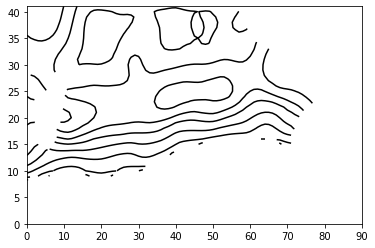

In [81]:
ds_dep_iso[170, :, :].plot(figsize=(10, 8))
plt.contour(ds_dep_iso[170, :, :], colors='k')

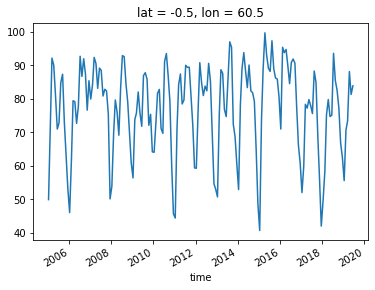

In [75]:
ds_dep_iso[:, 40, 20].plot()